## First let's import all the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform, exposure, filters, feature, color, data
import os
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import SIFT
from sklearn.cluster import KMeans

In [2]:
path = r'cars'
pics = os.listdir(path)
res = []

In [3]:
for i in pics:
    i = i.split("_")[:4]
    res.append(i)

In [4]:
temp = pd.DataFrame(res)
temp

0     1     2   3
0      Acura   ILX  2013  28
1      Acura   ILX  2013  28
2      Acura   ILX  2013  28
3      Acura   ILX  2013  28
4      Acura   ILX  2013  28
...      ...   ...   ...  ..
64459  Volvo  XC90  2020  50
64460  Volvo  XC90  2020  50
64461  Volvo  XC90  2020  50
64462  Volvo  XC90  2020  50
64463  Volvo  XC90  2020  50

[64464 rows x 4 columns]

In [5]:
def imNormalize(image):
    if len(image.shape)==2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b),axis=2) 

In [6]:

path = 'cars'
imagelist = os.listdir(path)
len(imagelist)

64464

## After making sure we have the right path and the correct amount of files let's specify the featuresize for a hog and process all the images extracting hog from them

In [7]:
featuresize = 2048
features = np.zeros((len(imagelist),featuresize))
labels = []

In [8]:
for i in range(len(imagelist)):
    image = io.imread(path + '/' + imagelist[i])
    image = transform.resize(image, [256,256])
    image = imNormalize(image)
    fd = feature.hog(image, orientations=8, pixels_per_cell=(16, 16),
            cells_per_block=(1, 1), visualize=False, feature_vector=True, channel_axis=2)
    features[i,:] = fd
    labels.append(path + '/' + imagelist[i])
    line = '\rProcessing '+ str(i+1) + ' of '+ str(len(imagelist))
    print(line, end='')
labels = np.array(labels)

Processing 64464 of 64464

## A quick look at the first 100 feature vectors 

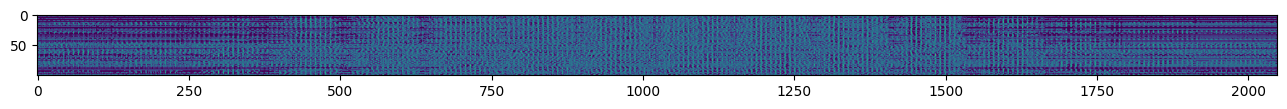

In [9]:
fig = plt.figure(figsize=(16,32))
plt.imshow(features[:100])
plt.show()

## Now I am creating a data frame that I will use two try and answer the questions of this project. Let's start with the first one: Can we distinguish between different car brands based on the image? First let's try SVM.

In [10]:
for i in range(len(features)):
    temp.iloc[i][3] = features[i]
temp

0     1     2                                                  3
0      Acura   ILX  2013  [0.5914753729255527, 0.35660094385014274, 0.32...
1      Acura   ILX  2013  [0.2405739958963593, 0.17116266101437155, 0.52...
2      Acura   ILX  2013  [0.20932811081930475, 0.0, 0.20269420045710176...
3      Acura   ILX  2013  [0.36920729740835795, 0.36920729740835795, 0.3...
4      Acura   ILX  2013  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
...      ...   ...   ...                                                ...
64459  Volvo  XC90  2020  [0.4133396534505454, 0.4133396534505454, 0.413...
64460  Volvo  XC90  2020  [0.49794401447665493, 0.07396861127803739, 0.4...
64461  Volvo  XC90  2020  [0.5029545620642125, 0.10710862922680198, 0.25...
64462  Volvo  XC90  2020  [0.4372085502045947, 0.0, 0.6339396087691668, ...
64463  Volvo  XC90  2020  [0.45314508975383844, 0.09567521900306811, 0.4...

[64464 rows x 4 columns]

In [11]:
features_ = []
labels_ = []
for i in temp.index:
    features_.append(temp.iloc[i][3])
    labels_.append(temp.iloc[i][0])

In [12]:
features_ = np.array(features_)
features_.shape
labels_ = np.array(labels_)
labels_.shape,features_.shape

((64464,), (64464, 2048))

In [13]:
train_features, test_features, train_labels, test_labels = train_test_split(features_,labels_)

In [259]:
model_ = LinearSVC()
model_.fit(train_features,train_labels)

C:\Users\Maven\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

0.3572392597851137


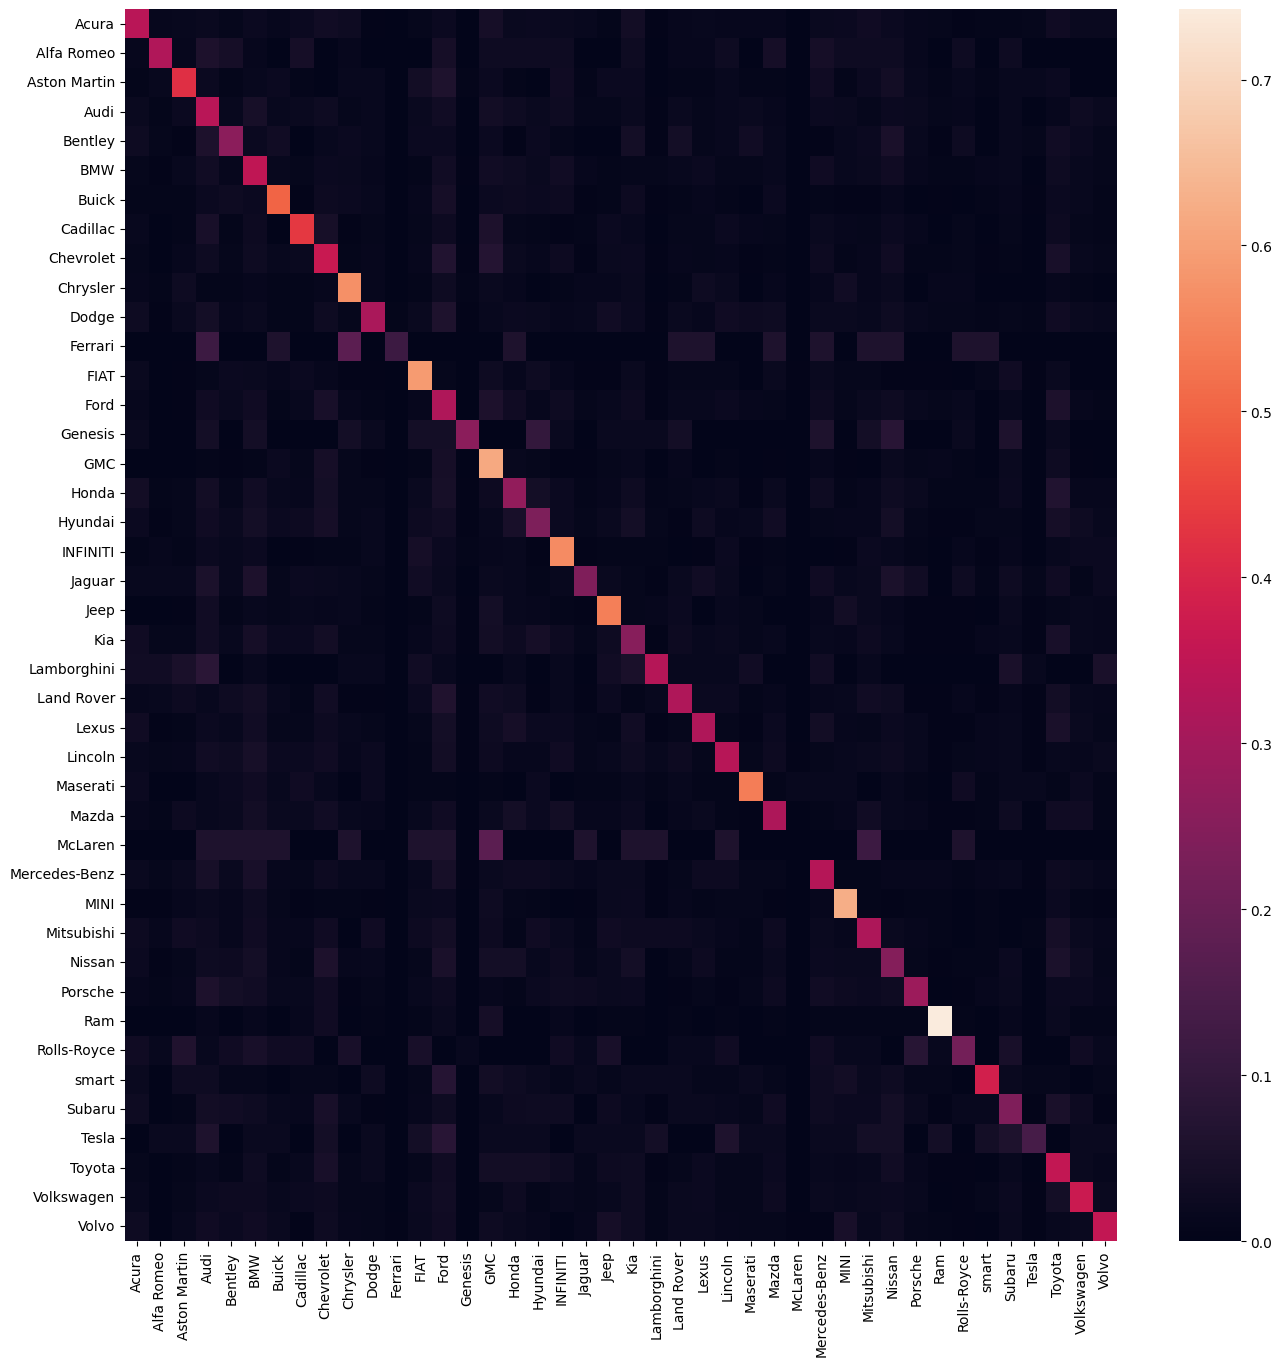

In [263]:
guessedlabels = model_.predict(test_features)
numClasses = len(temp[0].unique())

d = {}
t = temp[0].unique()
for key in range(len(t)):
    d[t[key] ] = key 

conf = np.zeros([numClasses,numClasses])

for i in range(len(test_labels)):
    real = d[test_labels[i]]
    guess = d[guessedlabels[i]]
    conf[real,guess] = conf[real][guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in d],
                  columns = [i for i in d])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=False)
x = np.diag(conf)
x = x[~np.isnan(x)]
print(np.average(x))

## Now, after 30 min SVM did not produce good results, let's try using random forest since it is better suited for a muiltidimensional data 

In [14]:
model = RandomForestClassifier(n_estimators=100, 
                               #random_state=11,
                               n_jobs=-1,
                               verbose = 1)
model.fit(train_features,train_labels)
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')
guessedlabels = model.predict(test_features)
model.score(test_features,test_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Average number of nodes 30783
Average maximum depth 91


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


0.5734673616281956

## The score for random forest is much better with 57%, let's double check it with theconfusion matrix

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


0.47490076007468135


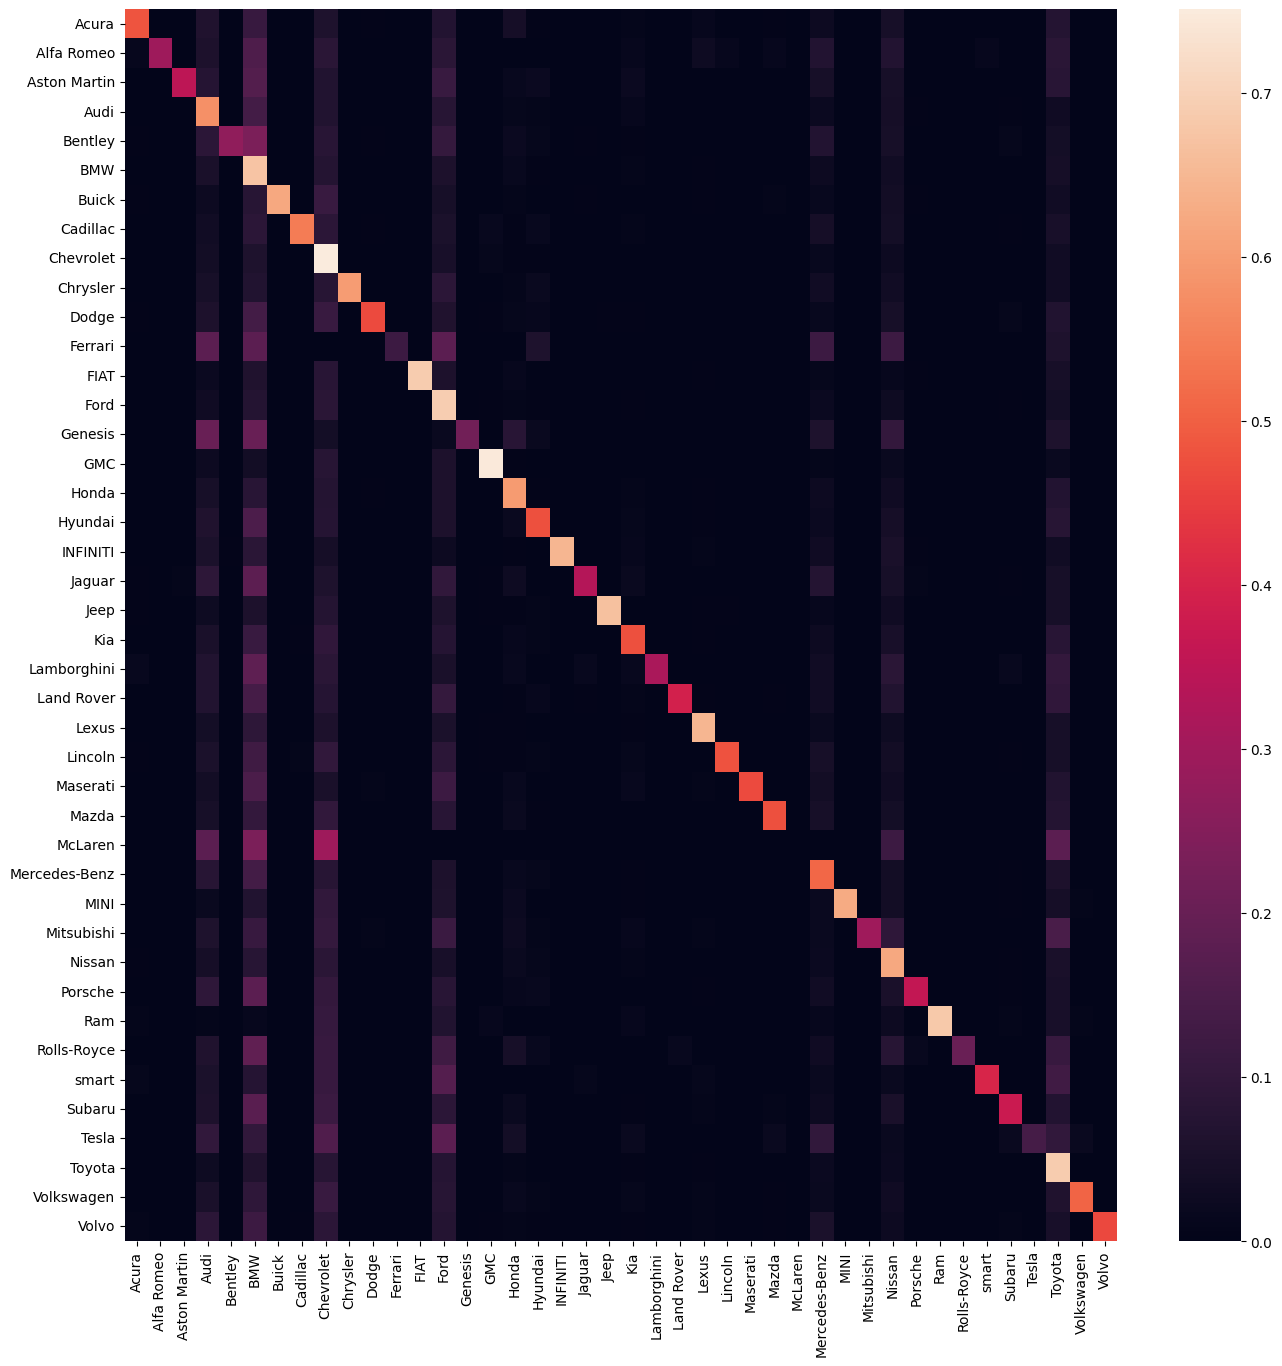

In [272]:
guessedlabels = model.predict(test_features)
numClasses = len(temp[0].unique())

d = {}
t = temp[0].unique()
for key in range(len(t)):
    d[t[key] ] = key 

conf = np.zeros([numClasses,numClasses])

for i in range(len(test_labels)):
    real = d[test_labels[i]]
    guess = d[guessedlabels[i]]
    conf[real,guess] = conf[real][guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in d],
                  columns = [i for i in d])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=False)
x = np.diag(conf)
x = x[~np.isnan(x)]
print(np.average(x))

## Not even 50%, well it is not surprising, I will discuss why later on but now let's try to answer the question whether we can distinguish between the years the car was made

In [ ]:
features1 = []
labels1 = []
for i in temp.index:
    features1.append(temp.iloc[i][3])
    labels1.append(temp.iloc[i][2])

In [15]:
features1 = np.array(features)
features1.shape

(64464, 2048)

In [16]:
labels1 = np.array(labels1)
labels1.shape

(64464,)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features1,labels1)
model1 = LinearSVC()
model1.fit(train_features,train_labels)

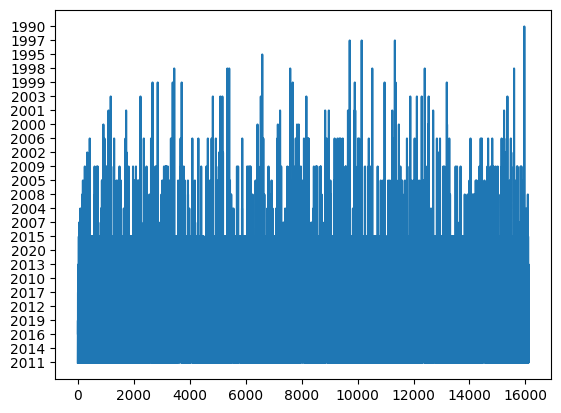

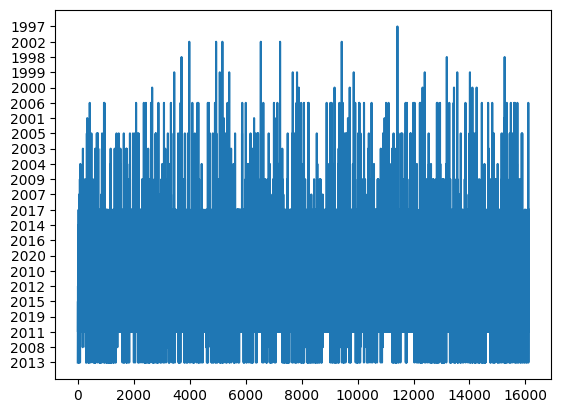

In [193]:
guessedlabels = model1.predict(test_features)
plt.plot(test_labels)
plt.show()
plt.plot(guessedlabels)

C:\Users\Maven\AppData\Local\Temp\ipykernel_10004\2267810442.py:18: RuntimeWarning: invalid value encountered in divide
  conf = conf / rowsums


0.23233772502107125


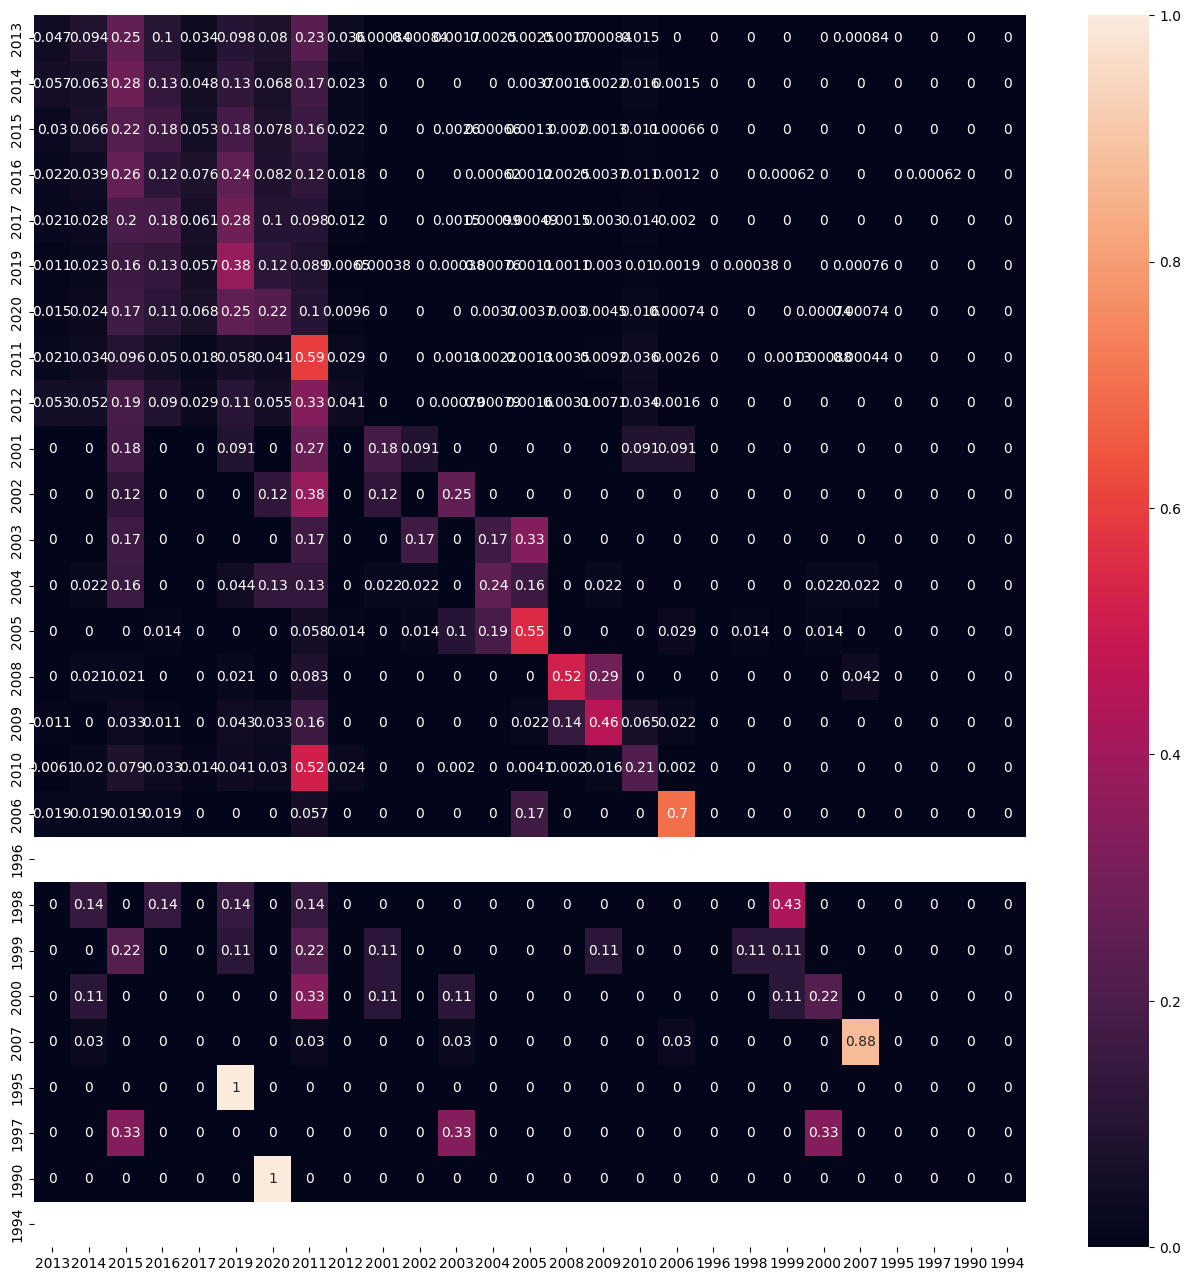

In [239]:
numClasses = len(temp[2].unique())

d = {}
t = temp[2].unique()
for key in range(len(t)):
    d[t[key] ] = key 

conf = np.zeros([numClasses,numClasses])

for i in range(len(test_labels)):
    real = d[test_labels[i]]
    guess = d[guessedlabels[i]]
    conf[real,guess] = conf[real][guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in d],
                  columns = [i for i in d])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=True)
x = np.diag(conf)
x = x[~np.isnan(x)]
print(np.average(x))

## 23% - Not the best result. Let's look at random forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               #random_state=11,
                               n_jobs=-1, verbose = 1)
model.fit(train_features,train_labels)
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')
guessedlabels = model.predict(test_features)
model.score(test_features,test_labels)

## A 37% accuracy is better than SVM but still not amazing

## Now let's look at the reasons

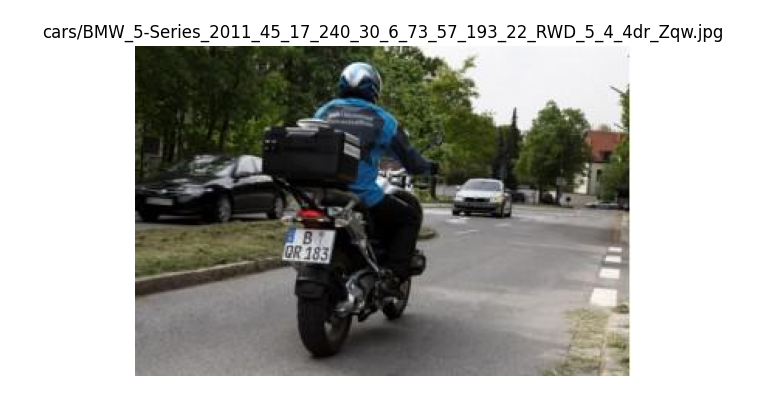

## This is one of the pictures in this dataset, well as you can see there is no bmw here. There are several hundreds of these kind of pictures and unfortunately they ruin the training process. Another reason is that I am using hog as a feature. Using hog implies that my feature vector will be sensitive to things like background and surroundings. And since this dataset was scraped from the web  it has flaws: repeating pictures, different backgrounds, different angles and so on. 

## It is surprising that even with this dataset random forest managed to get an accuracy of more than 50% with differentiating between 42 car brands, below is a plot of 25 pictures that are closely matched to the top left picture. (I tried both manhattan and euclidian distances and manhattan seemed to be best with this dataset)

In [29]:
def euclideanDistance(a,b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum((a-b)**2))

def manhattanDistance(a,b):
    a = np.array(a)
    b = np.array(b)
    return np.sum(np.abs(a-b))

In [30]:
image = io.imread("immm.jpg")
image = transform.resize(image, [256,256])
# querynum = np.random.randint(len(labels))
# print(querynum)
# queryimage = io.imread(labels[querynum])
# plt.imshow(queryimage)
# plt.axis('off')
# plt.title(labels[querynum])
# plt.show()

In [43]:
distances_m = np.zeros(len(labels))
distances_e = np.zeros(len(labels))
for i in range(len(labels)):
    distances_e[i] = euclideanDistance(fd,features[i,:])
    distances_m[i] = manhattanDistance(fd,features[i,:])
    line = '\rProcessing '+ str(i+1) + ' of '+ str(len(labels))
    print(line, end='')
    
order_e = np.argsort(distances_e)
order_m = np.argsort(distances_m)

Processing 14310 of 64464

Processing 27138 of 64464

Processing 40743 of 64464

Processing 53880 of 64464

Processing 64464 of 64464

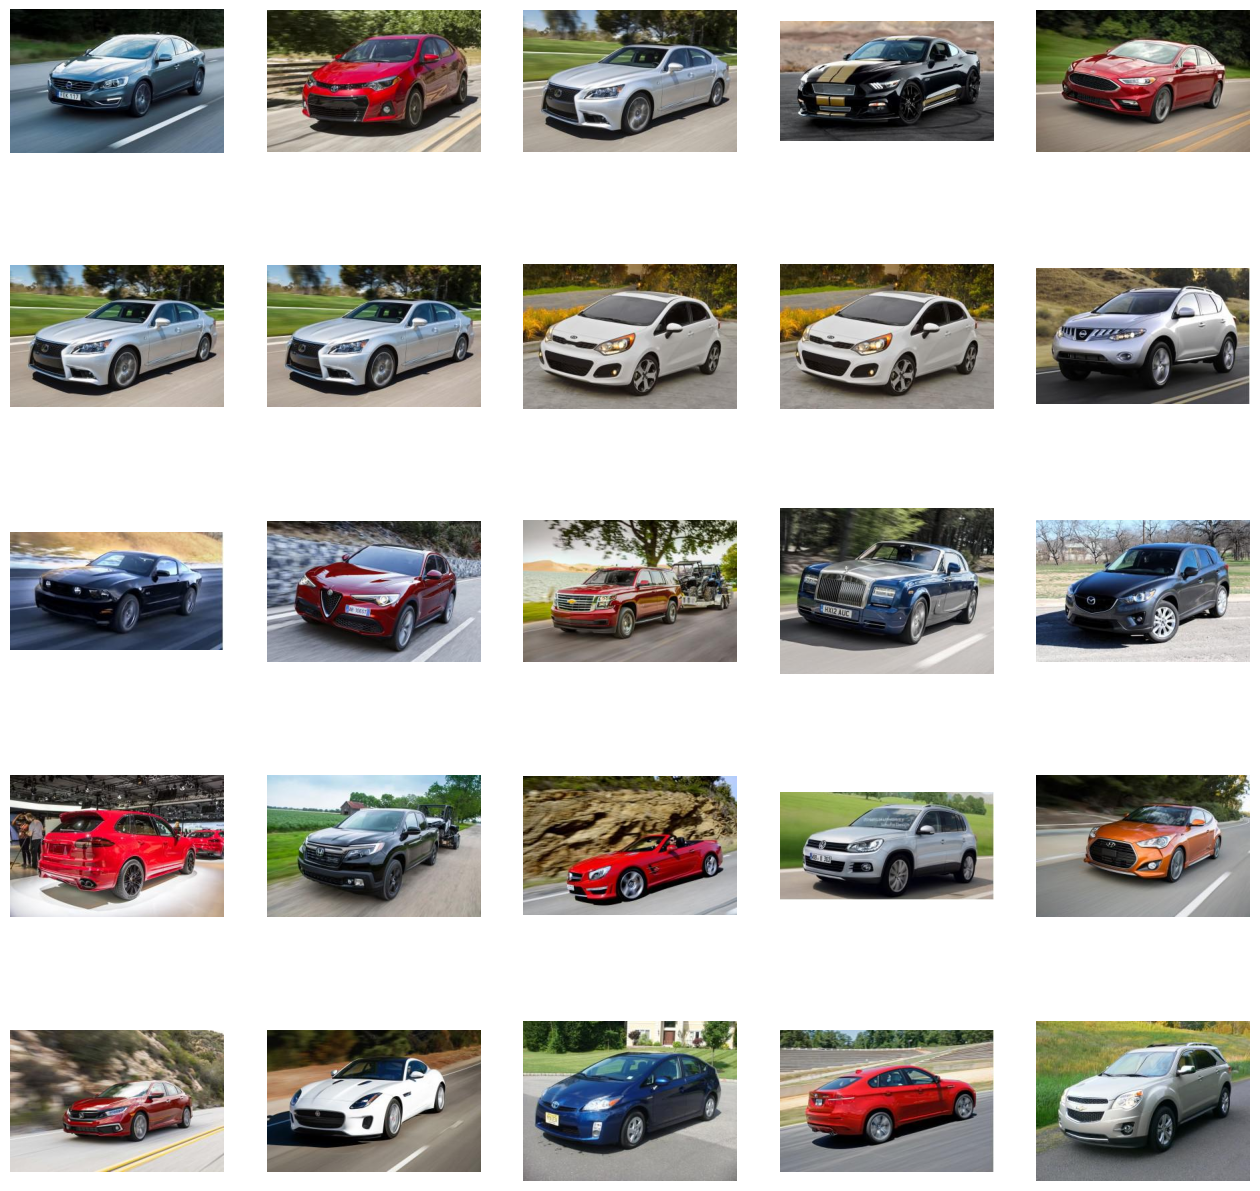

2011    6
2017    4
2014    3
2013    3
2020    3
2016    2
2015    2
2012    1
2019    1
Name: 0, dtype: int64

In [46]:
fig = plt.figure(figsize=[16,16])

rows = 5
cols = 5
years = []
for i in range(rows*cols):
    image = io.imread(labels[order_m[i]])
    years.append(labels[order_m[i]].split("_")[2])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()
pd.DataFrame(years)[0].value_counts()